#**Simulation**
Models a hospital environment with rooms of varying urgency, simulating 100 robots operating over 100 rounds, updating their trust scores in response to task success, failure, and cyber attacks (GPS spoofing, sensor noise, adversarial poisoning).
Used QUBO (Quadratic Unconstrained Binary Optimization) formulation to assign robots to rooms/tasks at each round, favoring high-trust agents for high-urgency tasks.

In [ ]:
#installs and imports
!pip install dimod
!pip install dwave-neal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import random
import dimod
from neal import SimulatedAnnealingSampler

In [ ]:
# parameters
num_agents = 100
total_rounds = 100

#trust updates
compromise_rate = 0.00005 #low rate
penalty = 0.05
reward = 0.02
alpha = 0.1
use_countermeasures = True

#defenses
countermeasure_success_threshold = 5
countermeasure_restore_amount = 0.01

#attacks
gps_spoof_severity = 0.1
sensor_noise_level = 0.05
adversarial_penalty = 0.1


In [ ]:
#Jaydine and Joseph's hospital layout

G = nx.Graph()

#hospital grid
floors = 3
x_rooms = 4
y_rooms = 3
room_spacing_x = 24
room_spacing_y = 26
floor_spacing_z = 15

room_ids = {}

for z in range(floors):
    for y in range(y_rooms):
        for x in range(x_rooms):
            room_num = z * 100 + 101 + (y * x_rooms + x)
            node_id = str(room_num)

            #assign room and urgrncy
            room_type = random.choice(["ward", "ICU", "OR", "storage", "lobby"])
            if room_type == "ICU":
                urgency_value = 0.9
            elif room_type == "OR":
                urgency_value = 0.7
            elif room_type == "ward":
                urgency_value = 0.5
            else:
                urgency_value = 0.2

            #add room nodes
            G.add_node(node_id,
                       type="room",
                       x=x * room_spacing_x,
                       y=y * room_spacing_y,
                       z=z * floor_spacing_z,
                       structural_integrity=1.0,
                       urgency=urgency_value,
                       occupants=random.randint(0, 3),
                       room_type=room_type)

            room_ids[(x, y, z)] = node_id

#adding connections
for z in range(floors):
    for y in range(y_rooms):
        for x in range(x_rooms - 1):
            n1 = room_ids[(x, y, z)]
            n2 = room_ids[(x + 1, y, z)]
            G.add_edge(n1, n2, edge_type="hallway", status="open", distance=room_spacing_x)

outer_cols = [0, x_rooms - 1]
for z in range(floors):
    for x in outer_cols:
        for y in range(y_rooms - 1):
            n1 = room_ids[(x, y, z)]
            n2 = room_ids[(x, y + 1, z)]
            G.add_edge(n1, n2, edge_type="hallway", status="open", distance=room_spacing_y)

for z in range(floors - 1):
    G.add_edge(room_ids[(0, 0, z)], room_ids[(0, 0, z + 1)], edge_type="elevator", status="open", distance=floor_spacing_z)
    G.add_edge(room_ids[(3, 2, z)], room_ids[(3, 2, z + 1)], edge_type="stair", status="open", distance=floor_spacing_z)

#exit nodes
room_102 = room_ids[(1, 0, 0)]
room_103 = room_ids[(2, 0, 0)]
exit_x = (G.nodes[room_102]["x"] + G.nodes[room_103]["x"]) / 2
exit_y = (G.nodes[room_102]["y"] + G.nodes[room_103]["y"]) / 2
exit_z = G.nodes[room_102]["z"]
exit_node_id = "EXIT"
G.add_node(exit_node_id, type="exit", x=exit_x, y=exit_y, z=exit_z)
G.add_edge(room_102, exit_node_id, edge_type="exit", status="open", distance=10)
G.add_edge(room_103, exit_node_id, edge_type="exit", status="open", distance=10)

print("Hospital layout graph created")


Hospital layout graph created


In [ ]:
#extract room data to dataframe

room_data = []
for node, data in G.nodes(data=True):
    if data.get("type") in ["room", "exit"]:
        room_data.append({
            'room_id': node,
            'x': data.get('x', 0),
            'y': data.get('y', 0),
            'z': data.get('z', 0),
            'room_type': data.get('room_type', 'unknown'),
            'structural_integrity': data.get('structural_integrity', 1.0),
            'urgency': data.get('urgency', 0.0),
            'occupants': data.get('occupants', 0)
        })

hospital_layout = pd.DataFrame(room_data)
print("\n Hospital layout DataFrame:")
display(hospital_layout)

tasks = hospital_layout['room_id'].tolist()
num_tasks = len(tasks)
print(f"\n Tasks list created with {num_tasks} rooms.")



 Hospital layout DataFrame:


,room_id,x,y,z,room_type,structural_integrity,urgency,occupants
0,101,0.0,0.0,0,storage,1.0,0.2,1
1,102,24.0,0.0,0,OR,1.0,0.7,0
2,103,48.0,0.0,0,ward,1.0,0.5,3
3,104,72.0,0.0,0,OR,1.0,0.7,1
4,105,0.0,26.0,0,ICU,1.0,0.9,3
5,106,24.0,26.0,0,OR,1.0,0.7,0
6,107,48.0,26.0,0,ward,1.0,0.5,2
7,108,72.0,26.0,0,lobby,1.0,0.2,1
8,109,0.0,52.0,0,ICU,1.0,0.9,1
9,110,24.0,52.0,0,lobby,1.0,0.2,0



 Tasks list created with 37 rooms.


In [ ]:
#simulating different attacks and defense countermeaure

def gps_spoofing_attack(robots, gps_spoofed_rooms):
    for r in robots.values():
        if r['assigned_room'] in gps_spoofed_rooms:
            r['trust'] = max(0.05, r['trust'] - gps_spoof_severity)

def sensor_noise_attack(robots):
    for r in robots.values():
        r['trust'] = max(0.05, min(0.95, r['trust'] + np.random.normal(0, sensor_noise_level)))

def adversarial_poisoning(robots, target_robot_ids):
    for tid in target_robot_ids:
        if tid in robots:
            robots[tid]['trust'] = max(0.05, robots[tid]['trust'] - adversarial_penalty)

def apply_countermeasures(robots):
    for r in robots.values():
        if r['success_count'] > countermeasure_success_threshold and r['trust'] < 0.9:
            r['trust'] = min(0.95, r['trust'] + countermeasure_restore_amount)

In [ ]:
#qubo function, assgin robots to tasks, maximizing trust

def run_qubo_solver(trust_matrix):
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #maximize trust
    for agent in range(num_agents):
        for task in range(num_tasks):
            var = f'A{agent}_T{task}'
            bqm.add_variable(var, -trust_matrix[agent][task])

    #one agent per task  constraint
    for task in range(num_tasks):
        for i in range(num_agents):
            for j in range(i+1, num_agents):
                bqm.add_interaction(f'A{i}_T{task}', f'A{j}_T{task}', 2)

    #one task per agent constraint
    for agent in range(num_agents):
        for i in range(num_tasks):
            for j in range(i+1, num_tasks):
                bqm.add_interaction(f'A{agent}_T{i}', f'A{agent}_T{j}', 2)


    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=10)
    return sampleset.first.sample

In [ ]:
#robot initialization
robots = {}
for i in range(num_agents):
    initial_trust = round(random.uniform(0.5, 0.95), 2) #random trust
    assigned_room = random.choice(tasks) #random room assignment
    robots[i] = {
        'trust': initial_trust,
        'trust_history': [initial_trust],
        'compromised': False,
        'success_count': 0,
        'fail_count': 0,
        'assigned_room': assigned_room
    }
print(f"\n Initialized {num_agents} robots with assigned rooms")


 Initialized 100 robots with assigned rooms


simulating 100 rounds, with each robot attempts a task each round, trust score updates (success/failure), attacks every round, compromised robots persistently degrade, countermeasures partially restore trust, qubo assings robots to tasks based on trust


In [ ]:
#main simulation loop

#tracks attacks per robot
robots_gps_hits = {i: 0 for i in range(num_agents)}
robots_noise_hits = {i: 0 for i in range(num_agents)}
robots_adv_hits = {i: 0 for i in range(num_agents)}

#begining of round
compromised_counts = []
success_counts = []
fail_counts = []
gps_attack_rounds = []
sensor_attack_rounds = []
adversarial_attack_rounds = []


for round_num in tqdm(range(total_rounds)):
    round_compromised = 0
    round_success = 0
    round_fail = 0

    #robot task attempt/trust updated
    for robot in robots.values():
        #persistent compromise spread
        robot['compromised'] = robot['compromised'] or (np.random.random() < compromise_rate)
        if robot['compromised']:
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.05, (1-alpha)*robot['trust'] + alpha*(robot['trust'] - penalty))
        else:
            if np.random.random() < robot['trust']:
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(0.95, (1-alpha)*robot['trust'] + alpha*(robot['trust'] + reward))
            else:
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.05, (1-alpha)*robot['trust'] + alpha*(robot['trust'] - penalty))

        #saves rounds trust
        robot['trust_history'].append(robot['trust'])


#applies attacks each round

    #GPS Spoofing Attack - targtes 2 random rooms
    gps_spoofed_rooms = random.sample(tasks, k=2)
    gps_spoofing_attack(robots, gps_spoofed_rooms)
    for robot_id, r in robots.items():
        if r['assigned_room'] in gps_spoofed_rooms:
            robots_gps_hits[robot_id] += 1
    gps_attack_rounds.append(round_num)

    #Sensor Noise Attack - hits all robots
    noisy_robots = random.sample(list(robots.keys()), k=int(0.3 * num_agents))
    for robot_id in noisy_robots:
        robots[robot_id]['trust'] = max(0.05, min(0.95, robots[robot_id]['trust'] + np.random.normal(0, sensor_noise_level)))
        robots_noise_hits[robot_id] += 1
    sensor_attack_rounds.append(round_num)

    #Adversarial Poisoning Attack - targets 3 random robots
    adversarial_targets = random.sample(list(robots.keys()), k=3)
    adversarial_poisoning(robots, adversarial_targets)
    for robot_id in adversarial_targets:
        robots_adv_hits[robot_id] += 1
    adversarial_attack_rounds.append(round_num)

    #defense countermeasures
    if use_countermeasures:
        apply_countermeasures(robots)

    #information recorded
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

    #qubo optimization for assignments
    trust_matrix = np.array([
        [r['trust'] for t in range(num_tasks)]
        for r in robots.values()
    ])
    assignment = run_qubo_solver(trust_matrix)

100%|██████████| 100/100 [09:56<00:00,  5.96s/it]


In [ ]:
#generating final assignment explanation table
assignment_list = [
    (var.split('_')[0], var.split('_')[1])
    for var, val in assignment.items() if val == 1
]

results = []

for robot_str, task_str in assignment_list:
    robot_id = int(robot_str.replace('A',''))
    task_idx = int(task_str.replace('T',''))
    room_id = tasks[task_idx]

    robot_trust = robots[robot_id]['trust']
    room_data = hospital_layout[hospital_layout['room_id'] == room_id].iloc[0]
    room_type = room_data['room_type']
    room_urgency = room_data['urgency']

    #explanations
    if robot_trust > 0.8 and room_urgency > 0.7:
        reasoning = "High-trust robot assigned to critical, high-urgency room"
    elif robot_trust < 0.6 and room_urgency < 0.4:
        reasoning = "Low-trust robot assigned to low-urgency task"
    else:
        reasoning = "Balanced assignment based on available trust"

    results.append({
        'Robot': robot_id,
        'Assigned Room': room_id,
        'Room Type': room_type,
        'Robot Trust (Final)': round(robot_trust, 2),
        'Room Urgency': room_urgency,
        'Total Successes': robots[robot_id]['success_count'],
        'Total Failures': robots[robot_id]['fail_count'],
        'GPS Attack Hits': robots_gps_hits.get(robot_id, 0),
        'Sensor Noise Hits': robots_noise_hits.get(robot_id, 0),
        'Adversarial Poisoning Hits': robots_adv_hits.get(robot_id, 0),
        'Reasoning': reasoning
    })

assignment_reasoning_df = pd.DataFrame(results)

print("\n Assignment Reasoning Table")
display(assignment_reasoning_df)



 Assignment Reasoning Table


,Robot,Assigned Room,Room Type,Robot Trust (Final),Room Urgency,Total Successes,Total Failures,GPS Attack Hits,Sensor Noise Hits,Adversarial Poisoning Hits,Reasoning
0,10,301,ward,0.90,0.5,70,30,7,29,2,Balanced assignment based on available trust
1,11,103,ward,0.81,0.5,93,7,3,27,2,Balanced assignment based on available trust
2,17,308,lobby,0.74,0.2,85,15,5,37,2,Balanced assignment based on available trust
3,18,EXIT,unknown,0.95,0.0,86,14,5,28,1,Balanced assignment based on available trust
4,1,102,OR,0.82,0.7,79,21,5,28,3,Balanced assignment based on available trust
5,21,210,storage,0.93,0.2,80,20,4,28,0,Balanced assignment based on available trust
6,22,111,ICU,0.94,0.9,86,14,5,39,3,"High-trust robot assigned to critical, high-ur..."
7,26,310,ICU,0.57,0.9,43,57,5,28,3,Balanced assignment based on available trust
8,27,107,ward,0.89,0.5,77,23,6,28,2,Balanced assignment based on available trust
9,36,307,ward,0.83,0.5,53,47,3,29,3,Balanced assignment based on available trust


In [ ]:
#shows which agent was assigned to which task
print("\n QUBO Assignment (Robot → Task):")
for var, val in assignment.items():
    if val == 1:
        print(var)

#displays dataframe
assignment_list = [(var.split('_')[0], var.split('_')[1]) for var, val in assignment.items() if val == 1]
assignment_df = pd.DataFrame(assignment_list, columns=['Robot', 'Task'])
display(assignment_df)



 QUBO Assignment (Robot → Task):
A10_T24
A11_T2
A17_T31
A18_T36
A1_T1
A21_T21
A22_T10
A26_T33
A27_T6
A36_T30
A3_T15
A40_T5
A43_T27
A45_T35
A46_T20
A47_T34
A4_T13
A56_T18
A57_T29
A59_T32
A5_T0
A63_T26
A66_T23
A67_T22
A69_T7
A71_T12
A73_T19
A81_T16
A83_T9
A85_T28
A87_T14
A8_T3
A90_T25
A93_T4
A94_T11
A95_T17
A99_T8


,Robot,Task
0,A10,T24
1,A11,T2
2,A17,T31
3,A18,T36
4,A1,T1
5,A21,T21
6,A22,T10
7,A26,T33
8,A27,T6
9,A36,T30


#**3D hospital layout**

Rooms - gray \\
Agent compromised - red \\
agent is good - green


In [ ]:
focus_agents = [10, 14, 20, 25, 30] #some subsets

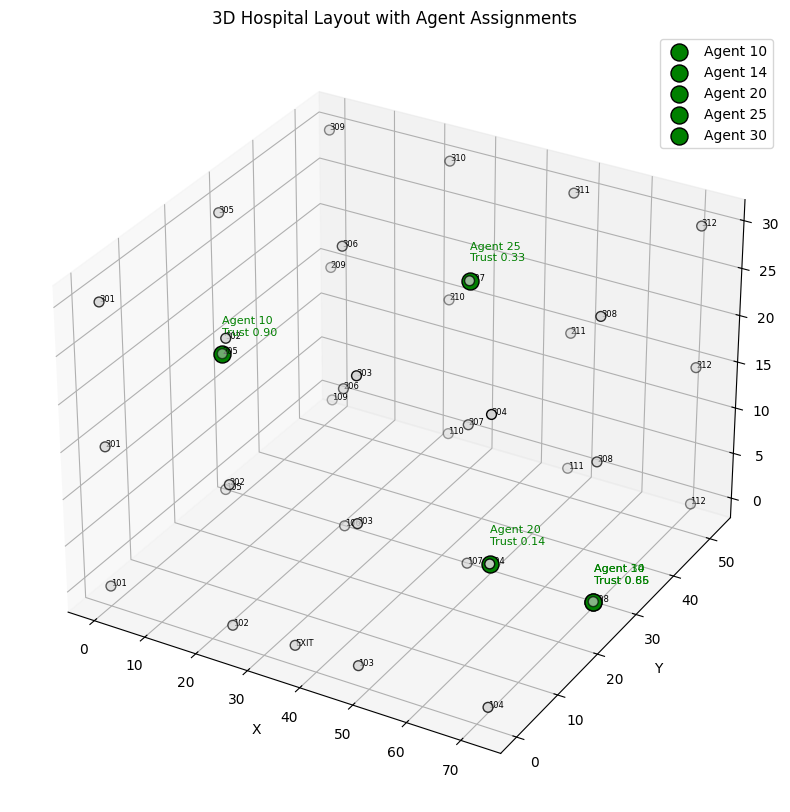

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

#plot all rooms (gray)
ax.scatter(
    hospital_layout['x'], hospital_layout['y'], hospital_layout['z'],
    c='lightgray', s=50, edgecolor='k'
)

#label rooms
for i, row in hospital_layout.iterrows():
    ax.text(row['x'], row['y'], row['z'], str(row['room_id']), fontsize=6)

#shows assigned rooms for focus agents
for agent_id in focus_agents:
    assigned_room = robots[agent_id]['assigned_room']
    room_row = hospital_layout[hospital_layout['room_id'] == assigned_room].iloc[0]

    #color base
    color = 'red' if robots[agent_id]['compromised'] else 'green'
    ax.scatter(
        room_row['x'], room_row['y'], room_row['z'],
        c=color, s=150, edgecolor='k', label=f"Agent {agent_id}"
    )
    ax.text(
        room_row['x'], room_row['y'], room_row['z']+2,
        f"Agent {agent_id}\nTrust {robots[agent_id]['trust']:.2f}",
        fontsize=8, color=color
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Hospital Layout with Agent Assignments')
ax.legend()
plt.show()

In [ ]:
#trust scores for some agents, shows trust decaying with attacks
zoom_start = 40
zoom_end = 45

for round_num in range(zoom_start, zoom_end):
    print(f"=== Round {round_num} ===")
    for agent_id in focus_agents:
        trust = robots[agent_id]['trust_history'][round_num]
        assigned_room = robots[agent_id]['assigned_room']
        print(f"Agent {agent_id}: Assigned to {assigned_room} | Trust: {trust:.2f}")
    print()

=== Round 40 ===
Agent 10: Assigned to 205 | Trust: 0.74
Agent 14: Assigned to 108 | Trust: 0.91
Agent 20: Assigned to 204 | Trust: 0.36
Agent 25: Assigned to 307 | Trust: 0.47
Agent 30: Assigned to 108 | Trust: 0.61

=== Round 41 ===
Agent 10: Assigned to 205 | Trust: 0.66
Agent 14: Assigned to 108 | Trust: 0.91
Agent 20: Assigned to 204 | Trust: 0.37
Agent 25: Assigned to 307 | Trust: 0.48
Agent 30: Assigned to 108 | Trust: 0.62

=== Round 42 ===
Agent 10: Assigned to 205 | Trust: 0.67
Agent 14: Assigned to 108 | Trust: 0.91
Agent 20: Assigned to 204 | Trust: 0.38
Agent 25: Assigned to 307 | Trust: 0.48
Agent 30: Assigned to 108 | Trust: 0.63

=== Round 43 ===
Agent 10: Assigned to 205 | Trust: 0.68
Agent 14: Assigned to 108 | Trust: 0.91
Agent 20: Assigned to 204 | Trust: 0.29
Agent 25: Assigned to 307 | Trust: 0.50
Agent 30: Assigned to 108 | Trust: 0.64

=== Round 44 ===
Agent 10: Assigned to 205 | Trust: 0.68
Agent 14: Assigned to 108 | Trust: 0.91
Agent 20: Assigned to 204 | Tru

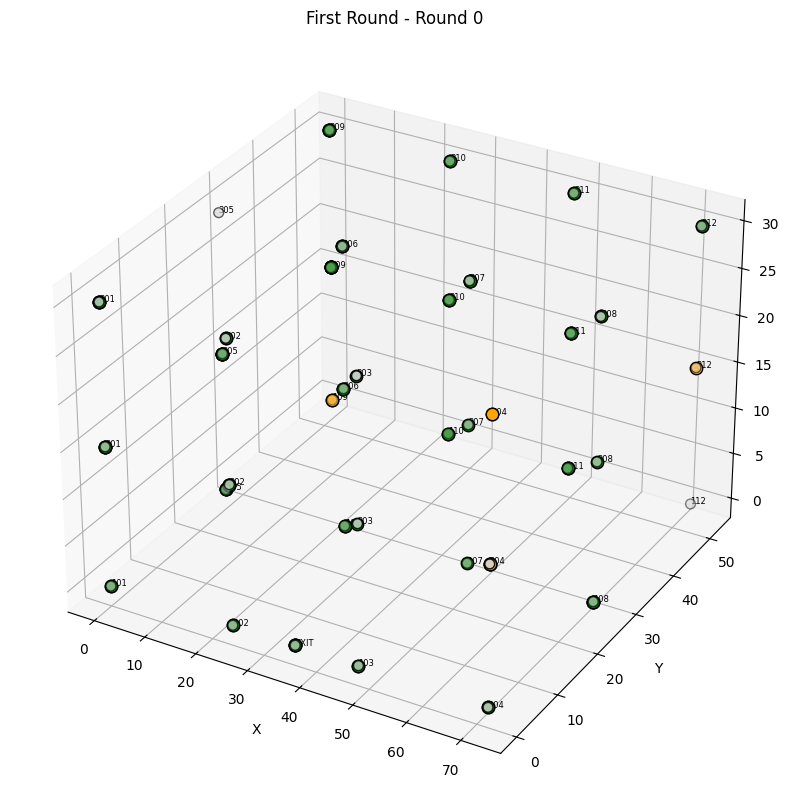

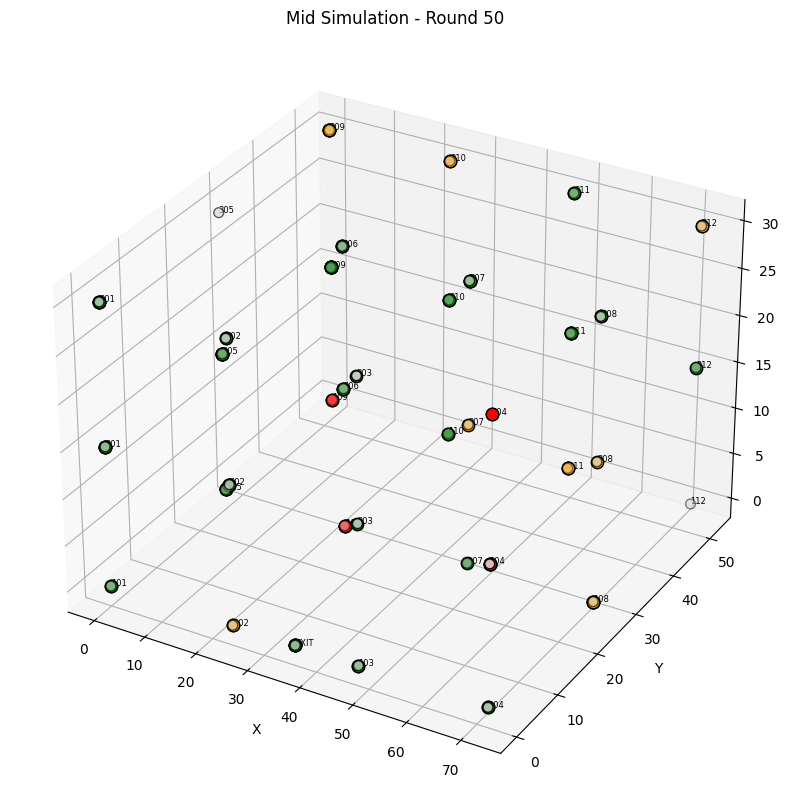

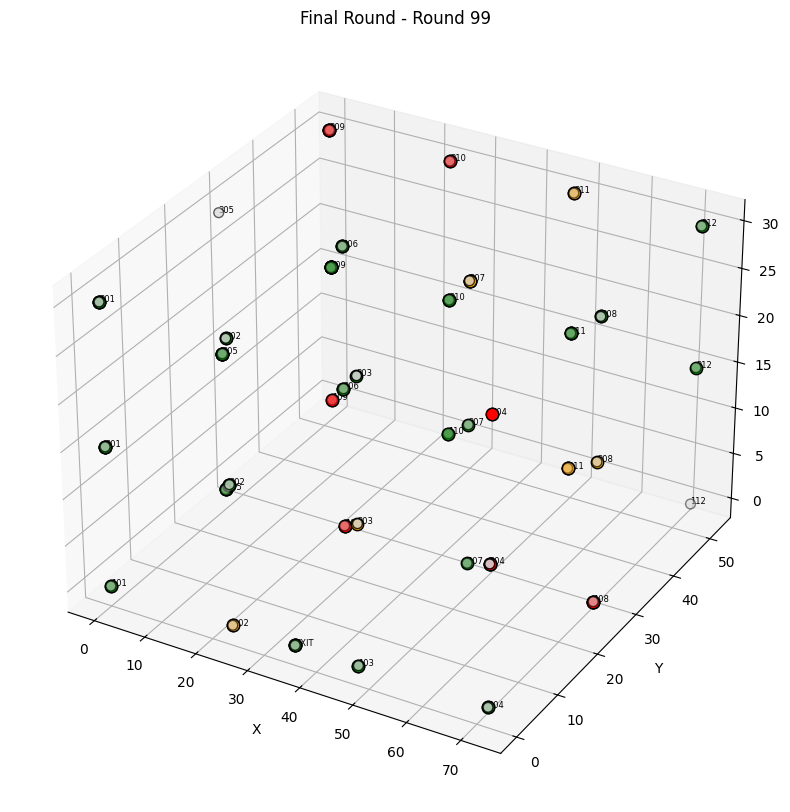

In [ ]:
#3D visualization (begining, mid and final rounds)

selected_rounds = [0, total_rounds // 2, total_rounds - 1]
titles = ['First Round', 'Mid Simulation', 'Final Round']

for idx, round_num in enumerate(selected_rounds):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    #plotting rooms
    ax.scatter(
        hospital_layout['x'], hospital_layout['y'], hospital_layout['z'],
        c='lightgray', s=50, edgecolor='k'
    )

    #labeling rooms
    for i, row in hospital_layout.iterrows():
        ax.text(row['x'], row['y'], row['z'], str(row['room_id']), fontsize=6)

    #plot all agents colored by trust
    for agent_id, robot in robots.items():
        assigned_room = robot['assigned_room']
        room_row = hospital_layout[hospital_layout['room_id'] == assigned_room].iloc[0]
        trust_score = robot['trust_history'][round_num]

        if trust_score < 0.3:
            color = 'red'
        elif trust_score < 0.6:
            color = 'orange'
        else:
            color = 'green'

        ax.scatter(
            room_row['x'], room_row['y'], room_row['z'],
            c=color, s=80, edgecolor='k'
        )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{titles[idx]} - Round {round_num}')
    plt.show()